In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange


In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [3]:
from community.data.datasets import get_datasets_symbols
from community.utils.plotting import plot_grid, create_gifs
from community.data.tasks import get_task_target, get_task_family_dict


In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256


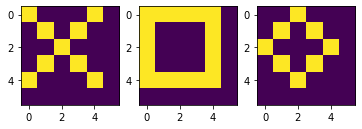

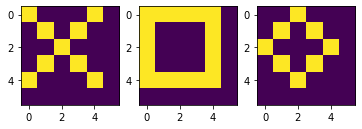

In [5]:
n_classes = 60

data_config = {
    "data_size": (10000, 5000),
    "nb_steps": 50,
    "n_symbols": n_classes - 1,
    "symbol_type": "mod_5",
    "input_size": 60,
    "static": True,
    "common_input": True,
    'n_diff_symbols' : 3
}

if data_config["static"]:
    data_config["nb_steps"] = 6
    data_config["data_size"] = [d for d in data_config["data_size"]]

n_classes_per_digit = n_classes // data_config['n_diff_symbols']

n_bits = np.ceil(np.log2(n_classes)).astype(int)
loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)


In [26]:
all_targets = datasets[1].data[1]
task_family, factors = get_task_family_dict(all_targets, n_classes_per_digit)

In [29]:
factors

[array([-1,  1,  1]),
 array([0, 0, 1]),
 array([0, 1, 0]),
 array([0, 1, 1]),
 array([ 1, -1,  1]),
 array([1, 0, 0]),
 array([1, 0, 1]),
 array([ 1,  1, -1]),
 array([1, 1, 0]),
 array([1, 1, 1])]

In [30]:
[(t.max(), t.min()) for t in task_family.values()]

[(tensor(57), tensor(0)),
 (tensor(19), tensor(0)),
 (tensor(19), tensor(0)),
 (tensor(38), tensor(0)),
 (tensor(57), tensor(1)),
 (tensor(19), tensor(0)),
 (tensor(38), tensor(0)),
 (tensor(57), tensor(1)),
 (tensor(38), tensor(0)),
 (tensor(57), tensor(0))]

/home/gb21/.conda/envs/community/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


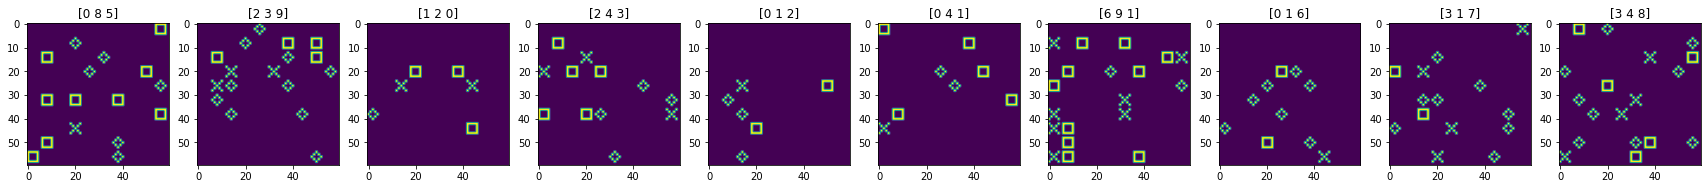

In [7]:
data, targets = datasets[0].data[:-1]
s = 50
fig, axs = plt.subplots(1, 10, figsize=(30, 20))
for i, ax in enumerate(axs) : 
    if not data_config['common_input'] : 
        ax.imshow(data[i+s][-1].reshape(120, 60))
        ax.set_title(targets[i+s].data.numpy())
    else :
        ax.imshow(data[i+s][-1].reshape(60, 60))
        ax.set_title(targets[i+s].data.numpy())

## Init

In [8]:
from community.funcspec.single_model_loop import (
    init_and_train,
    train_and_compute_metrics,
    train_community,
    init_community, 
    init_optimizers
)

from community.data.process import process_data

from community.utils.configs import get_training_dict
import yaml
from yaml.loader import SafeLoader

with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)


In [9]:
task = config["task"] = 'family' #[['0', '1'], ['1', '2'], ['0', '2']] #"both"
config["training"]["decision_params"] = ("last", "both")

config['model_params']['agents_params']['n_in'] = data_config["input_size"] ** 2
config['model_params']['agents_params']['n_hidden'] = 50
config['model_params']['agents_params']['n_readouts'] = 2 #data_config['n_diff_symbols']

config['model_params']['n_agents'] = data_config['n_diff_symbols']
config["model_params"]["n_readouts"] = [2] * config['model_params']['n_agents']

if config['model_params']['n_agents'] == 2 : 
    config['model_params']['agents_params']['n_out'] = n_classes_per_digit
    config["model_params"]['readout_from'] = [[0, 1], [0, 1]]
else : 
    if task == 'family' : 
        config['model_params']['agents_params']['n_out'] = n_classes
        config["model_params"]["n_readouts"] = data_config['n_diff_symbols'] ** 3 - 1
        config["model_params"]['readout_from'] = None
    else : 
        config['model_params']['agents_params']['n_out'] = n_classes_per_digit
        config["model_params"]['readout_from'] = [[0, 1], [1, 2], [0, 2]]

config['model_params']['connections_params']['sparsity'] = .1

community = init_community(config['model_params'])
optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

config['datasets']['n_classes'] = n_classes
config['datasets']['n_classes_per_digit'] = n_classes_per_digit


config['use_tqdm'] = True

data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task='family')
data, target = data.to(device), target.to(device)
out, states, fconns = community(data)

print(out.shape)

torch.Size([6, 26, 256, 30])


In [10]:
raise KeyboardInterrupt

KeyboardInterrupt: 

## Training

In [ ]:
train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True, 
    use_tqdm=True
);


Train Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/Loss.cu:194: nll_loss_forward_no_reduce_cuda_kernel: block: [0,0,0], thread: [97,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
/opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/Loss.cu:194: nll_loss_forward_no_reduce_cuda_kernel: block: [0,0,0], thread: [226,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
/opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/Loss.cu:194: nll_loss_forward_no_reduce_cuda_kernel: block: [0,0,0], thread: [169,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
/opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/Loss.cu:194: nll_loss_forward_no_reduce_cuda_kernel: block: [0,0,0], thread: [48,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
/opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/Loss.cu:194: nll_loss_forward_no_red

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
3 ** 4 - 1

80

## Metrics

In [ ]:
diff_metric = lambda c: (c[0] - c[1]) / c.sum()
norms = [1, 2, 'fro', 'nuc', np.inf]

In [ ]:
from community.funcspec.bottleneck import readout_retrain

bottleneck_metrics = readout_retrain(
    community,
    loaders,
    n_classes,
    n_agents=config['model_params']['n_agents'],
    n_digits=data_config['n_diff_symbols'],
    n_epochs=5,
    n_tests=1,
    use_tqdm=True,
    symbols=True,
    force_connections=False,
)


Bottleneck Metric Trials :   0%|          | 0/3 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

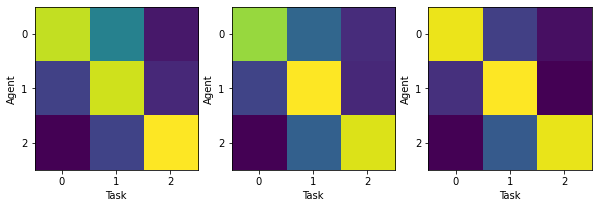

In [ ]:

accs = lambda s : bottleneck_metrics["accs"][:, :, s]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for s, ax in enumerate(axs) : 
    
    c = ax.imshow(accs(s))

    ax.set_ylabel('Agent')
    ax.set_xlabel('Task')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])

#plt.colorbar(c)

In [ ]:
norm_det = lambda m, norm : np.abs(np.linalg.det(m))/ np.linalg.norm(m, norm)

In [ ]:
np.array([[norm_det(accs(s), n) for n in norms] for s in range(3)])

array([[0.02255579, 0.02496408, 0.0228875 , 0.0156075 , 0.02387202],
       [0.05813962, 0.06683399, 0.06004461, 0.03967743, 0.06654554],
       [0.33558452, 0.37450662, 0.32986167, 0.21311685, 0.36713806]],
      dtype=float32)

In [ ]:
accs(-1)

array([[0.9455181 , 0.46731085, 0.32319078],
       [0.28618422, 0.94983554, 0.26192436],
       [0.25226152, 0.4068668 , 0.91241777]], dtype=float32)

In [ ]:
#m = np.array([[1, 1, 0], [0, 0.5, 1], [0.5, 0, 1]])
#m = np.eye(4) * 0.5
[norm_det(accs(2), n) for n in norms]

[0.3222093, 0.36476666, 0.3220067, 0.20829998, 0.3385411]

In [ ]:
np.linalg.matrix_rank(m)

2